# mount drive

In [1]:
use_colaboratory = True
if use_colaboratory:
    import os
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/tabular-playground-series-mar-2022/notebook')

Mounted at /content/drive


In [31]:
# import packages
import datetime
import holidays
import itertools
import math
import pickle

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

### 実験1
時間の特徴量のみ  
x, y, directionはone-hot-encoding

In [ ]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")

data = pd.concat([train, test])
data["time"] = pd.to_datetime(data.time)
data["hour"] = data.time.dt.hour
data["minute"] = data.time.dt.minute
data["weekday"] = data.time.dt.weekday
data["isAM"] = (data.hour < 12).astype("int")
data["isAMrush"] = ((6 <= data.hour) & (data.hour <= 10)).astype("int")
data["isPMrush"] = ((15 <= data.hour) & (data.hour <= 20)).astype("int")
data["isSun"] = (data.weekday == 6).astype("int")
data["isSat"] = (data.weekday == 5).astype("int")

us_holidays = holidays.US()
data["isholiday"] = (data.time.map(lambda x: x in us_holidays)).astype("int")

data = pd.get_dummies(data, columns=["x", "y", "direction"])

train = data.iloc[:len(train)]
test = data.iloc[len(train):]

X_train = train.drop(["time", "congestion"], axis=1)
y_train = train["congestion"]
X_test = test.drop(["time", "congestion"], axis=1)
X_train.head(1)

In [ ]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = {}

cv = TimeSeriesSplit(n_splits=5)

params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx[fold_idx] = [tr_idx, val_idx]
    print(f"======== fold: {fold_idx} ========")
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 11.2236	valid_1's l1: 11.3364
[20]	training's l1: 9.91814	valid_1's l1: 10.0526
[30]	training's l1: 9.13738	valid_1's l1: 9.27912
[40]	training's l1: 8.51442	valid_1's l1: 8.65843
[50]	training's l1: 8.12829	valid_1's l1: 8.27368
[60]	training's l1: 7.85526	valid_1's l1: 8.00059
[70]	training's l1: 7.63323	valid_1's l1: 7.78448
[80]	training's l1: 7.44877	valid_1's l1: 7.60669
[90]	training's l1: 7.32219	valid_1's l1: 7.48965
[100]	training's l1: 7.21992	valid_1's l1: 7.39521
[110]	training's l1: 7.15098	valid_1's l1: 7.33226
[120]	training's l1: 7.0804	valid_1's l1: 7.26816
[130]	training's l1: 7.0092	valid_1's l1: 7.20229
[140]	training's l1: 6.95801	valid_1's l1: 7.1554
[150]	training's l1: 6.90425	valid_1's l1: 7.10578
[160]	training's l1: 6.85625	valid_1's l1: 7.06213
[170]	training's l1: 6.82256	valid_1's l1: 7.03493
[180]	training's l1: 6.79963	valid_1's l1: 7.01624
[190]	

In [ ]:
with open("../output/y_preds_012-1.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_012-1.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_012-1.pkl", "wb") as f:
    pickle.dump(oof_train, f)

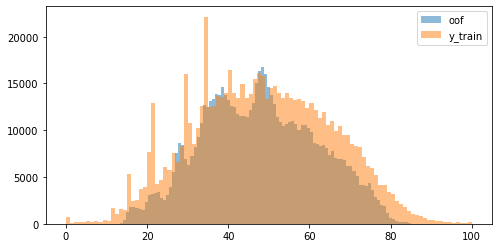

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[cv_idx[0][1][0]:], bins=100, label="oof", alpha=0.5)
plt.hist(y_train.iloc[cv_idx[0][1][0]:], bins=100, label="y_train", alpha=0.5)
plt.legend()
plt.show()

In [ ]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[6.344605424664298, 6.364252959320996, 6.6183717959368575, 6.3497851747630465, 6.675406870343943]
6.4704844450058285


In [ ]:
f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=True)
df_importance.plot.barh(x="f_name")

### 実験2
x, y, directionをlabel encodingにする

In [ ]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")

In [ ]:
data = pd.concat([train, test])
data["time"] = pd.to_datetime(data.time)
data["hour"] = data.time.dt.hour
data["minute"] = data.time.dt.minute
data["weekday"] = data.time.dt.weekday
data["isAM"] = (data.hour < 12).astype("int")
data["isAMrush"] = ((6 <= data.hour) & (data.hour <= 10)).astype("int")
data["isPMrush"] = ((15 <= data.hour) & (data.hour <= 20)).astype("int")
data["isSun"] = (data.weekday == 6).astype("int")
data["isSat"] = (data.weekday == 5).astype("int")

us_holidays = holidays.US()
data["isholiday"] = (data.time.map(lambda x: x in us_holidays)).astype("int")

In [ ]:
le = LabelEncoder()
data.x = le.fit_transform(data.x)
data.y = le.fit_transform(data.y)
data.direction = le.fit_transform(data.direction)

In [ ]:
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

In [ ]:
X_train = train.drop(["time", "congestion"], axis=1)
y_train = train["congestion"]
X_test = test.drop(["time", "congestion"], axis=1)
X_train.head(1)

,x,y,direction,hour,minute,weekday,isAM,isAMrush,isPMrush,isSun,isSat,isholiday
row_id,,,,,,,,,,,,
0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = {}

cv = TimeSeriesSplit(n_splits=5)

params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx[fold_idx] = [tr_idx, val_idx]
    print(f"======== fold: {fold_idx} ========")
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 11.433	valid_1's l1: 11.5364
[20]	training's l1: 10.1094	valid_1's l1: 10.2192
[30]	training's l1: 9.22605	valid_1's l1: 9.33882
[40]	training's l1: 8.61731	valid_1's l1: 8.73821
[50]	training's l1: 8.13899	valid_1's l1: 8.26983
[60]	training's l1: 7.85529	valid_1's l1: 7.99176
[70]	training's l1: 7.64302	valid_1's l1: 7.78554
[80]	training's l1: 7.48933	valid_1's l1: 7.63589
[90]	training's l1: 7.36007	valid_1's l1: 7.51188
[100]	training's l1: 7.27898	valid_1's l1: 7.43854
[110]	training's l1: 7.21158	valid_1's l1: 7.37908
[120]	training's l1: 7.15727	valid_1's l1: 7.32881
[130]	training's l1: 7.07032	valid_1's l1: 7.24782
[140]	training's l1: 6.99769	valid_1's l1: 7.18193
[150]	training's l1: 6.94592	valid_1's l1: 7.13465
[160]	training's l1: 6.90753	valid_1's l1: 7.10277
[170]	training's l1: 6.86626	valid_1's l1: 7.0664
[180]	training's l1: 6.83392	valid_1's l1: 7.0382
[190]	

In [ ]:
with open("../output/y_preds_012-2.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_012-2.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_012-2.pkl", "wb") as f:
    pickle.dump(oof_train, f)

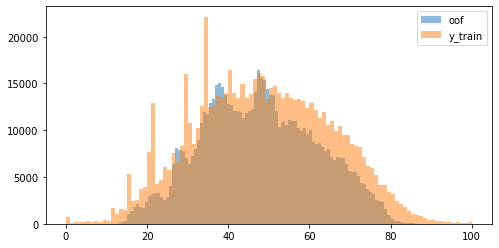

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[cv_idx[0][1][0]:], bins=100, label="oof", alpha=0.5)
plt.hist(y_train.iloc[cv_idx[0][1][0]:], bins=100, label="y_train", alpha=0.5)
plt.legend()
plt.show()

In [ ]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[6.346635558823783, 6.398855393116662, 6.608423977319588, 6.361657684335159, 6.688070363910569]
6.480728595501152


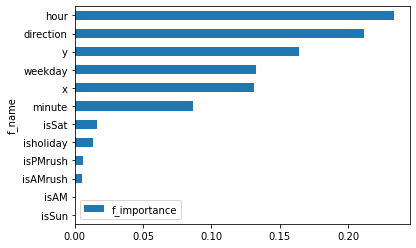

In [ ]:
bf_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=True)
df_importance.plot.barh(x="f_name")

### 実験3
実験1から"isAM", "isSun"を削除

In [ ]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")

data = pd.concat([train, test])
data["time"] = pd.to_datetime(data.time)
data["hour"] = data.time.dt.hour
data["minute"] = data.time.dt.minute
data["weekday"] = data.time.dt.weekday
data["isAMrush"] = ((6 <= data.hour) & (data.hour <= 10)).astype("int")
data["isPMrush"] = ((15 <= data.hour) & (data.hour <= 20)).astype("int")
data["isSat"] = (data.weekday == 5).astype("int")

us_holidays = holidays.US()
data["isholiday"] = (data.time.map(lambda x: x in us_holidays)).astype("int")

data = pd.get_dummies(data, columns=["x", "y", "direction"])

train = data.iloc[:len(train)]
test = data.iloc[len(train):]

X_train = train.drop(["time", "congestion"], axis=1)
y_train = train["congestion"]
X_test = test.drop(["time", "congestion"], axis=1)
X_train.head(1)

,hour,minute,weekday,isAMrush,isPMrush,isSat,isholiday,x_0,x_1,x_2,...,y_2,y_3,direction_EB,direction_NB,direction_NE,direction_NW,direction_SB,direction_SE,direction_SW,direction_WB
row_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = {}

cv = TimeSeriesSplit(n_splits=5)

params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx[fold_idx] = [tr_idx, val_idx]
    print(f"======== fold: {fold_idx} ========")
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 11.2236	valid_1's l1: 11.3364
[20]	training's l1: 9.91814	valid_1's l1: 10.0526
[30]	training's l1: 9.13738	valid_1's l1: 9.27912
[40]	training's l1: 8.51442	valid_1's l1: 8.65843
[50]	training's l1: 8.12829	valid_1's l1: 8.27368
[60]	training's l1: 7.85526	valid_1's l1: 8.00059
[70]	training's l1: 7.63323	valid_1's l1: 7.78448
[80]	training's l1: 7.44877	valid_1's l1: 7.60669
[90]	training's l1: 7.32219	valid_1's l1: 7.48965
[100]	training's l1: 7.21992	valid_1's l1: 7.39521
[110]	training's l1: 7.15098	valid_1's l1: 7.33226
[120]	training's l1: 7.0804	valid_1's l1: 7.26816
[130]	training's l1: 7.0092	valid_1's l1: 7.20229
[140]	training's l1: 6.95801	valid_1's l1: 7.1554
[150]	training's l1: 6.90425	valid_1's l1: 7.10578
[160]	training's l1: 6.85625	valid_1's l1: 7.06213
[170]	training's l1: 6.82256	valid_1's l1: 7.03493
[180]	training's l1: 6.79963	valid_1's l1: 7.01624
[190]	

In [ ]:
with open("../output/y_preds_012-3.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_012-3.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_012-3.pkl", "wb") as f:
    pickle.dump(oof_train, f)

In [ ]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[6.344605424664298, 6.364252959320996, 6.6183717959368575, 6.3497851747630465, 6.675406870343943]
6.4704844450058285


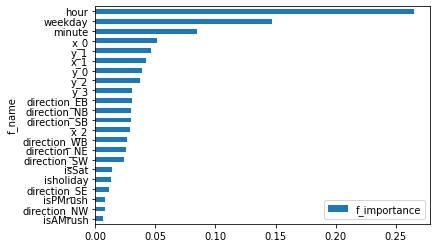

In [ ]:
f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=True)
df_importance.plot.barh(x="f_name")

### 実験4
実験3に加えて，座標，方角ごとに曜日，時間，分でまとめて平均を取って特徴量とする  
各データポイントより過去のデータで平均を計算

In [361]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")

In [362]:
train.time = pd.to_datetime(train.time)
test.time = pd.to_datetime(test.time)

In [363]:
# trainデータをwide formatに変換
wide_train = pd.pivot(train, index="time", columns=["x", "y", "direction"], values="congestion")

# 曜日，時間，分のカラムを作成
wide_train = wide_train.reset_index()
wide_train["weekday"] = wide_train.time.dt.weekday
wide_train["hour"] = wide_train.time.dt.hour
wide_train["minute"] = wide_train.time.dt.minute

# 曜日，時間，分のループ用配列
weekdays = wide_train.weekday.unique()
hours = wide_train.hour.unique()
minutes = wide_train.minute.unique()

# 平均値の格納用配列 (あとでNaNを代入することになるのでfloat指定)
tmp = np.zeros_like(wide_train.loc[:, [0, 1, 2]]).astype("float")

# 曜日，時間，分の組み合わせでループして，各時点より過去のデータでの平均を計算
for wd, h, m in itertools.product(weekdays, hours, minutes):
    df = wide_train[(wide_train.weekday == wd) & (wide_train.hour == h) & (wide_train.minute == m)].loc[:, [0, 1, 2]]
    df = df.shift(1).cumsum() / np.repeat(np.arange(df.shape[0]).reshape((-1, 1)), df.shape[1], axis=1)
    tmp[df.index, :] = df.values

# "wd_h_min_mean"というカラムをtrain setに追加
tmp = pd.DataFrame(tmp, index=wide_train.time, columns=wide_train.columns[1:-3])
tmp = tmp.stack(["x", "y", "direction"])
tmp.name = "wd_h_min_mean"
train = train.merge(tmp, how="left", left_on=["time", "x", "y", "direction"], right_index=True)

In [364]:
# train, testに時系列の特徴量を追加
us_holidays = holidays.US()

for df in [train, test]:
    df["hour"] = df.time.dt.hour
    df["minute"] = df.time.dt.minute
    df["weekday"] = df.time.dt.weekday
    df["isAMrush"] = ((6 <= df.hour) & (df.hour <= 10)).astype("int")
    df["isPMrush"] = ((15 <= df.hour) & (df.hour <= 20)).astype("int")
    df["isSat"] = (df.weekday == 5).astype("int")
    df["isholiday"] = (df.time.map(lambda x: x in us_holidays)).astype("int")

# test setのwd_h_min_meanを追加
tmp = train.groupby(["x", "y", "direction", "weekday", "hour", "minute"]).mean()
tmp.name = "wd_h_min_mean"
test = test.merge(tmp, how="left", left_on=["x", "y", "direction", "weekday", "hour", "minute"], right_index=True)

data = pd.concat([train, test])
data = pd.get_dummies(data, columns=["x", "y", "direction"])

train = data.iloc[:len(train)]
test = data.iloc[len(train):]
train = train[~train.wd_h_min_mean.isna()]

In [365]:
X_train = train.drop(["time", "congestion"], axis=1)
y_train = train["congestion"]
X_test = test.drop(["time", "congestion"], axis=1)

In [366]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = {}

cv = TimeSeriesSplit(n_splits=5)

params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx[fold_idx] = [tr_idx, val_idx]
    print(f"======== fold: {fold_idx} ========")

    # 学習用，バリデーション用に分割
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 10.287	valid_1's l1: 10.1472
[20]	training's l1: 8.46044	valid_1's l1: 8.23888
[30]	training's l1: 7.56075	valid_1's l1: 7.2955
[40]	training's l1: 7.11681	valid_1's l1: 6.84164
[50]	training's l1: 6.88861	valid_1's l1: 6.62566
[60]	training's l1: 6.7537	valid_1's l1: 6.51419
[70]	training's l1: 6.67242	valid_1's l1: 6.46046
[80]	training's l1: 6.61836	valid_1's l1: 6.43012
[90]	training's l1: 6.58008	valid_1's l1: 6.41576
[100]	training's l1: 6.5537	valid_1's l1: 6.41056
[110]	training's l1: 6.52446	valid_1's l1: 6.40081
[120]	training's l1: 6.50142	valid_1's l1: 6.39302
[130]	training's l1: 6.48356	valid_1's l1: 6.3886
[140]	training's l1: 6.46546	valid_1's l1: 6.38308
[150]	training's l1: 6.4474	valid_1's l1: 6.3768
[160]	training's l1: 6.43239	valid_1's l1: 6.37347
[170]	training's l1: 6.41815	valid_1's l1: 6.37116
[180]	training's l1: 6.40423	valid_1's l1: 6.36759
[190]	trai

In [367]:
with open("../output/y_preds_012-4.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_012-4.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_012-4.pkl", "wb") as f:
    pickle.dump(oof_train, f)

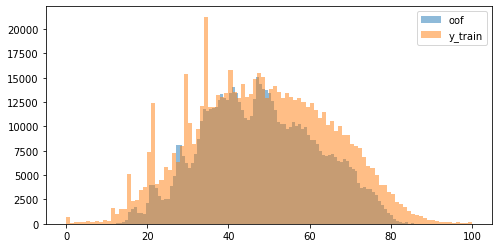

In [368]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[cv_idx[0][1][0]:], bins=100, label="oof", alpha=0.5)
plt.hist(y_train.iloc[cv_idx[0][1][0]:], bins=100, label="y_train", alpha=0.5)
plt.legend()
plt.show()

In [369]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[6.323012093292901, 6.4445633714756685, 6.456572257352367, 6.295051156032343, 6.700135708143853]
6.443866917259426


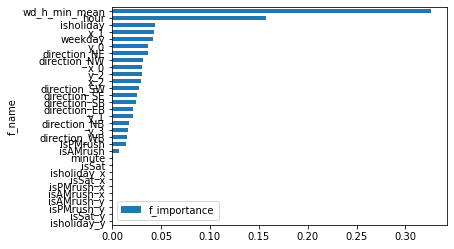

In [370]:
f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=True)
df_importance.plot.barh(x="f_name")

### submit

In [373]:
with open("../output/y_preds_012-4.pkl", "rb") as f:
    y_preds = pickle.load(f)

In [374]:
submission = pd.read_csv("../input/sample_submission.csv")
submission.congestion = y_preds[-1]

In [375]:
submission.to_csv("../submit/submission_012.csv", index=False)

In [376]:
import json
with open('../../kaggle.json') as f:
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

!pip install kaggle --upgrade
!kaggle -v

Kaggle API 1.5.12


In [377]:
# submission
!kaggle competitions submit tabular-playground-series-mar-2022 -f ../submit/submission_012.csv -m "012"

100% 57.6k/57.6k [00:00<00:00, 132kB/s]
Successfully submitted to Tabular Playground Series - Mar 2022